In [1]:
import keras
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 10} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
print("Tensor Flow Version: {}".format(tf.__version__))

Tensor Flow Version: 1.13.1


In [3]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv",
    na_values=['NA','?'])

display(df[0:5])

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from scipy.stats import zscore

# Prepare data - apply z-score to ALL x columns
# Only do this if you have no categoricals (and are sure you want to use z-score across the board)
x_columns = df.columns.drop('diagnosis').drop('id')
for col in x_columns:
    df[col] = zscore(df[col])

# Convert to numpy - Regression
x = df[x_columns].values
y = df['diagnosis'].map({'M':1,"B":0}) # Binary classification, M is 1 and B is 0

In [7]:
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## Binary Classification

In [11]:
# Classification neural network
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(1, #We have 1 neuron because of the binary classification
                activation='linear', kernel_initializer='random_normal')) 
model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 426 samples, validate on 143 samples
Epoch 1/1000
 - 0s - loss: 1.8929 - acc: 0.6291 - val_loss: 1.0377 - val_acc: 0.6224
Epoch 2/1000
 - 0s - loss: 0.8503 - acc: 0.6338 - val_loss: 0.6027 - val_acc: 0.6434
Epoch 3/1000
 - 0s - loss: 0.4881 - acc: 0.7066 - val_loss: 0.2804 - val_acc: 0.8531
Epoch 4/1000
 - 0s - loss: 0.2644 - acc: 0.9038 - val_loss: 0.2303 - val_acc: 0.9510
Epoch 5/1000
 - 0s - loss: 0.1933 - acc: 0.9390 - val_loss: 0.1834 - val_acc: 0.9650
Epoch 6/1000
 - 0s - loss: 0.1159 - acc: 0.9671 - val_loss: 0.0673 - val_acc: 0.9790
Epoch 7/1000
 - 0s - loss: 0.0942 - acc: 0.9765 - val_loss: 0.0586 - val_acc: 0.9790
Epoch 8/1000
 - 0s - loss: 0.0816 - acc: 0.9836 - val_loss: 0.1469 - val_acc: 0.9790
Epoch 9/1000
 - 0s - loss: 0.0753 - acc: 0.9883 - val_loss: 0.1455 - val_acc: 0.9860
Epoch 10/1000
 - 0s - loss: 0.0700 - acc: 0.9883 - val_loss: 0.1418 - val_acc: 0.9860
Epoch 11/1000
 - 0s - loss: 0.0660 - acc: 0.9883 - val_loss: 0.1405 - val_acc: 0.9860
Epoch 12/1000
Res

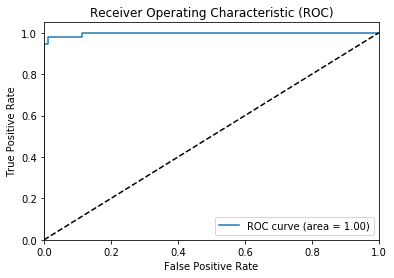

In [12]:
pred = model.predict(x_test)
plot_roc(pred,y_test)

## Multiclass classification

In [13]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [14]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(y.shape[1], # You have to have as many neurons as you have categories
                activation='softmax',kernel_initializer='random_normal'))
model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 1500 samples, validate on 500 samples
Epoch 1/1000
 - 0s - loss: 1.5522 - acc: 0.3773 - val_loss: 1.1655 - val_acc: 0.4980
Epoch 2/1000
 - 0s - loss: 1.1576 - acc: 0.4760 - val_loss: 1.0967 - val_acc: 0.4980
Epoch 3/1000
 - 0s - loss: 1.1044 - acc: 0.4920 - val_loss: 1.0540 - val_acc: 0.5120
Epoch 4/1000
 - 0s - loss: 0.9788 - acc: 0.5767 - val_loss: 0.9201 - val_acc: 0.6400
Epoch 5/1000
 - 0s - loss: 0.8506 - acc: 0.6653 - val_loss: 0.9024 - val_acc: 0.6340
Epoch 6/1000
 - 0s - loss: 0.8083 - acc: 0.6787 - val_loss: 0.8182 - val_acc: 0.6740
Epoch 7/1000
 - 0s - loss: 0.7668 - acc: 0.6920 - val_loss: 0.8399 - val_acc: 0.6640
Epoch 8/1000
 - 0s - loss: 0.7575 - acc: 0.6833 - val_loss: 0.7854 - val_acc: 0.6940
Epoch 9/1000
 - 0s - loss: 0.7463 - acc: 0.6927 - val_loss: 0.7826 - val_acc: 0.7060
Epoch 10/1000
 - 0s - loss: 0.7426 - acc: 0.6967 - val_loss: 0.8478 - val_acc: 0.6400
Epoch 11/1000
 - 0s - loss: 0.7253 - acc: 0.7020 - val_loss: 0.7656 - val_acc: 0.7060
Epoch 12/1000
 -

In [15]:
#predict classes
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)

In [16]:
[products[i] for i in pred]

['c',
 'b',
 'b',
 'c',
 'c',
 'c',
 'c',
 'c',
 'b',
 'c',
 'c',
 'b',
 'c',
 'b',
 'b',
 'b',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'a',
 'b',
 'a',
 'b',
 'b',
 'b',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'c',
 'b',
 'c',
 'c',
 'c',
 'c',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'a',
 'b',
 'c',
 'b',
 'b',
 'c',
 'b',
 'b',
 'c',
 'c',
 'c',
 'c',
 'b',
 'c',
 'c',
 'b',
 'b',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'c',
 'c',
 'b',
 'b',
 'a',
 'c',
 'c',
 'a',
 'b',
 'b',
 'b',
 'c',
 'd',
 'b',
 'b',
 'b',
 'b',
 'c',
 'b',
 'c',
 'b',
 'b',
 'b',
 'c',
 'b',
 'c',
 'c',
 'b',
 'b',
 'b',
 'b',
 'c',
 'c',
 'c',
 'c',
 'c',
 'b',
 'b',
 'a',
 'a',
 'b',
 'd',
 'b',
 'b',
 'b',
 'a',
 'b',
 'b',
 'b',
 'c',
 'c',
 'b',
 'b',
 'b',
 'c',
 'b',
 'b',
 'c',
 'b',
 'c',
 'c',
 'c',
 'b',
 'c',
 'c',
 'a',
 'b',
 'c',
 'c',
 'b',
 'c',
 'b',
 'c',
 'b',
 'b',
 'c',
 'b',
 'c',
 'c',
 'b'

In [17]:
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.676


## Calculate Classification Log Loss
Accuracy is like a final exam with no partial credit. However, neural networks can predict a probability of each of the target classes. Neural networks will give high probabilities to predictions that are more likely. Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

The following code shows the output of predict_proba:

In [18]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model.predict(x_test)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)

Numpy array of predictions


array([[0.    , 0.1623, 0.6864, 0.1501, 0.0011, 0.    , 0.    ],
       [0.    , 0.8122, 0.1854, 0.    , 0.0023, 0.0001, 0.    ],
       [0.    , 0.7847, 0.2099, 0.0001, 0.005 , 0.0003, 0.    ],
       [0.    , 0.3648, 0.6226, 0.0102, 0.0023, 0.0001, 0.    ],
       [0.    , 0.0876, 0.6045, 0.3075, 0.0004, 0.    , 0.    ]],
      dtype=float32)

As percent probability
[ 0.0005 16.2303 68.6444 15.0114  0.1082  0.0049  0.0004]
Log loss score: 0.7391831717938184


C:\Users\Larbi\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


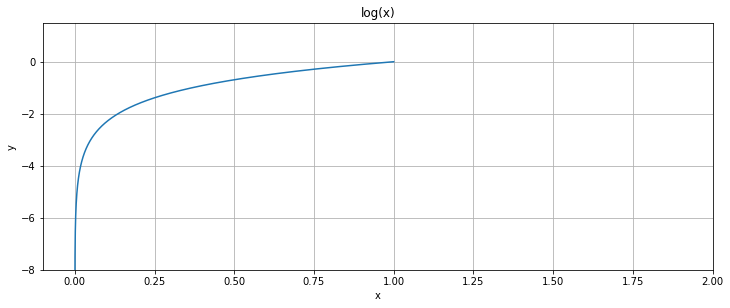

In [19]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

Confusion matrix, without normalization
[[ 21   1   0   0   0   0   0]
 [  4 202  42   1   0   0   0]
 [  0  71 112   4   0   0   0]
 [  0   0  11   3   0   0   0]
 [  0   8   0   0   0   0   0]
 [  9   8   0   0   0   0   0]
 [  3   0   0   0   0   0   0]]
Normalized confusion matrix
[[0.95 0.05 0.   0.   0.   0.   0.  ]
 [0.02 0.81 0.17 0.   0.   0.   0.  ]
 [0.   0.38 0.6  0.02 0.   0.   0.  ]
 [0.   0.   0.79 0.21 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.53 0.47 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]]


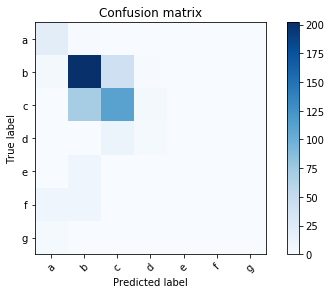

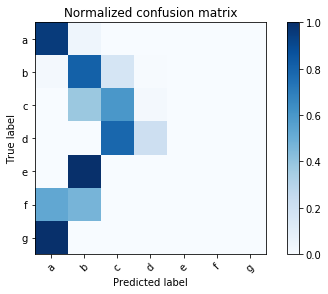

In [20]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()